# Autoencoders for anomaly detection

The notebook is adapted from https://www.cs.toronto.edu/~lczhang/360/lec/w05/autoencoder.html

In [1]:
import sys; sys.path.insert(0, '..')

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from source.scenario import ScenarioDatasetMNIST, ToTensor, scenarios
from source.autoencoders import *

In [35]:
DATA_DIR = "/Users/ccaloian/Temp/dl-pytorch/data/MNIST/novelty-detection"
PROJ_DIR = "/Users/ccaloian/Projects/Anomaly-Detection"
SCENARIO = "5"

# Train Autoencoder

In [36]:
# Training Dataset
train_set = ScenarioDatasetMNIST(root_dir=DATA_DIR, partition="train", scenario=SCENARIO, transform=ToTensor())

model = Autoencoder()
max_epochs = 20
outputs = train_ae(model, train_set, num_epochs=max_epochs)

Epoch:1, Loss:0.0151
Epoch:2, Loss:0.0071
Epoch:3, Loss:0.0061
Epoch:4, Loss:0.0050
Epoch:5, Loss:0.0040
Epoch:6, Loss:0.0039
Epoch:7, Loss:0.0036
Epoch:8, Loss:0.0036
Epoch:9, Loss:0.0036
Epoch:10, Loss:0.0029
Epoch:11, Loss:0.0031
Epoch:12, Loss:0.0032
Epoch:13, Loss:0.0028
Epoch:14, Loss:0.0034
Epoch:15, Loss:0.0026
Epoch:16, Loss:0.0031
Epoch:17, Loss:0.0031
Epoch:18, Loss:0.0028
Epoch:19, Loss:0.0025
Epoch:20, Loss:0.0025


## Plot images and their reconstructions

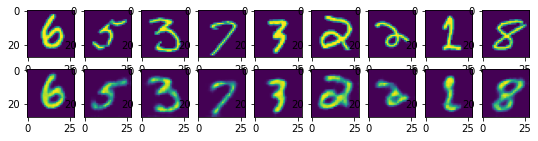

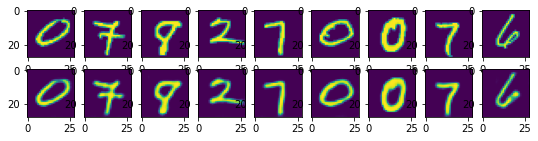

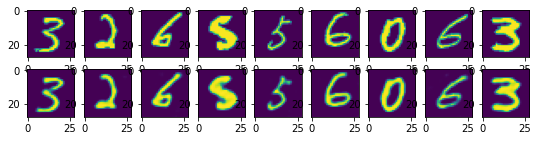

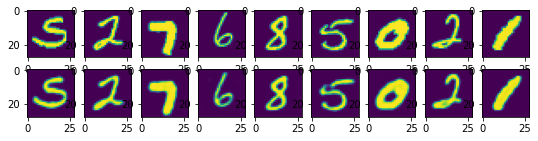

In [38]:
def plot_images_and_reconstructions(outputs, max_epochs):
    for k in range(0, max_epochs, 5):
        plt.figure(figsize=(9, 2))
        imgs = outputs[k][1].detach().numpy()
        recon = outputs[k][2].detach().numpy()
        for i, item in enumerate(imgs):
            if i >= 9: break
            plt.subplot(2, 9, i+1)
            plt.imshow(item[0])

        for i, item in enumerate(recon):
            if i >= 9: break
            plt.subplot(2, 9, 9+i+1)
            plt.imshow(item[0])

plot_images_and_reconstructions(outputs, max_epochs)

## Load validation and test datasets

In [ ]:
# Validation Dataset
val_set = ScenarioDatasetMNIST( root_dir=DATA_DIR, partition="validation", scenario=SCENARIO, transform=ToTensor())
val_loader = DataLoader(val_set, batch_size=1, shuffle=True, num_workers=0)

# Test Dataset
test_set = ScenarioDatasetMNIST(root_dir=DATA_DIR, partition="test", scenario=SCENARIO, transform=ToTensor())
test_loader = DataLoader(test_set, batch_size=1, shuffle=True, num_workers=0)

## Get embeddings for validation and test data

In [ ]:
val_embs, val_labs = ae_embed(model, val_loader)
val_shape = val_embs.shape
val_embs = val_embs.reshape(val_shape[0], val_shape[-1]).detach().numpy()
val_labs = val_labs.reshape(val_shape[0]).detach().numpy()

test_embs, test_labs = ae_embed(model, test_loader)
test_shape = test_embs.shape
test_embs = test_embs.reshape(test_shape[0], test_shape[-1]).detach().numpy()
test_labs = test_labs.reshape(test_shape[0]).detach().numpy()

## Use UMAP to reduce the embeddings to 2D

In [ ]:
import umap

reducer = umap.UMAP()
umap_emb = reducer.fit_transform(test_embs)
umap_emb.shape

In [ ]:
n_test_labels = np.unique(test_labs).size
plt.scatter(umap_emb[:, 0], umap_emb[:, 1], c=test_labs, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(n_test_labels + 1)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Digits dataset (scenario 3)', fontsize=10);
# plt.savefig(PROJ_DIR + f"/figures/UMAP-proj-latent-space-testset-scenario-{SCENARIO}.png")

## Calculate the MSE of the reconstruction

In [ ]:
mses, labels = ae_mse(model, test_loader)

In [ ]:
inliers = mses[np.isin(labels.flatten(), scenarios[SCENARIO]["inlier_classes"])]
outliers = mses[np.isin(labels.flatten(), scenarios[SCENARIO]["outlier_classes"])]
print(inliers.shape)
print(outliers.shape)

In [ ]:
in_n, in_bins, in_patches = plt.hist(inliers.detach().numpy(), 50, facecolor='green', alpha=0.75)
out_n, out_bins, out_patches = plt.hist(outliers.detach().numpy(), 50, facecolor='red', alpha=0.75)
# plt.savefig(PROJ_DIR + f"/figures/MSE-recon-err-scenario-{SCENARIO}.png")

# Train Variational Autoencoder

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Validation Dataset
val_set = ScenarioDatasetMNIST(root_dir=DATA_DIR, partition="validation", scenario=SCENARIO, transform=ToTensor())
val_loader = DataLoader(val_set, batch_size=1, shuffle=True, num_workers=0)

# Test Dataset
test_set = ScenarioDatasetMNIST(root_dir=DATA_DIR, partition="test", scenario=SCENARIO, transform=ToTensor())
test_loader = DataLoader(test_set, batch_size=64, shuffle=True, num_workers=0)


# Training Dataset
train_set = ScenarioDatasetMNIST(root_dir=DATA_DIR, partition="train", scenario=SCENARIO, transform=ToTensor())
train_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)

vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 308357


In [40]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for batch in train_loader:
        
        image_batch = batch["images"].to(device)
        labels_batch = batch["labels"].to(device)
        
        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    
    if (epoch + 1) % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [10 / 100] average reconstruction error: 20522.089825
Epoch [20 / 100] average reconstruction error: 19746.316064
Epoch [30 / 100] average reconstruction error: 19329.667583
Epoch [40 / 100] average reconstruction error: 19055.875422
Epoch [50 / 100] average reconstruction error: 18842.308016
Epoch [60 / 100] average reconstruction error: 18670.536018
Epoch [70 / 100] average reconstruction error: 18563.824048
Epoch [80 / 100] average reconstruction error: 18478.481018
Epoch [90 / 100] average reconstruction error: 18394.646929
Epoch [100 / 100] average reconstruction error: 18323.792739


## Evaluate on validation set

In [41]:
# Validation Dataset
val_set = ScenarioDatasetMNIST(root_dir=DATA_DIR, partition="validation", scenario=SCENARIO, transform=ToTensor())
val_loader = DataLoader(val_set, batch_size=64, shuffle=True, num_workers=0)

# set to evaluation mode
vae.eval()

val_loss_avg, num_batches = 0, 0
for batch in val_loader:
    
    with torch.no_grad():
    
        image_batch = batch["images"].to(device)
        labels_batch = batch["labels"].to(device)
        
        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        val_loss_avg += loss.item()
        num_batches += 1
    
val_loss_avg /= num_batches
print('average reconstruction error: %f' % (val_loss_avg))

average reconstruction error: 9176.072846


In [42]:
print(num_batches)

233


## Visualize reconstructions

Original images


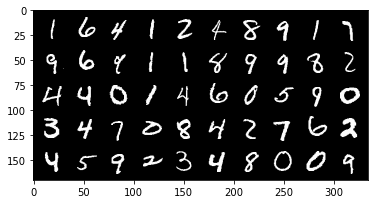

VAE reconstruction:


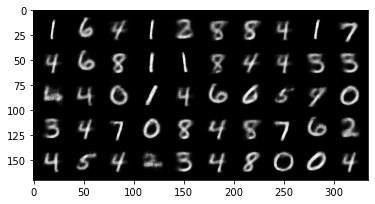

In [43]:
# Test Dataset
test_set = ScenarioDatasetMNIST(root_dir=DATA_DIR, partition="test", scenario=SCENARIO, transform=ToTensor())
test_loader = DataLoader(test_set, batch_size=64, shuffle=True, num_workers=0)

plt.ion()

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = utils.make_grid(images[0:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

test_data = iter(test_loader).next()
images, labels = test_data["images"], test_data["labels"]

# First visualise the original images
print('Original images')
show_image(utils.make_grid(images[0:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)

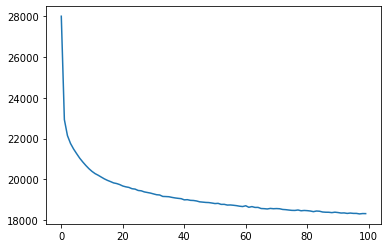

In [44]:
plt.plot(train_loss_avg)
plt.show()